In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv

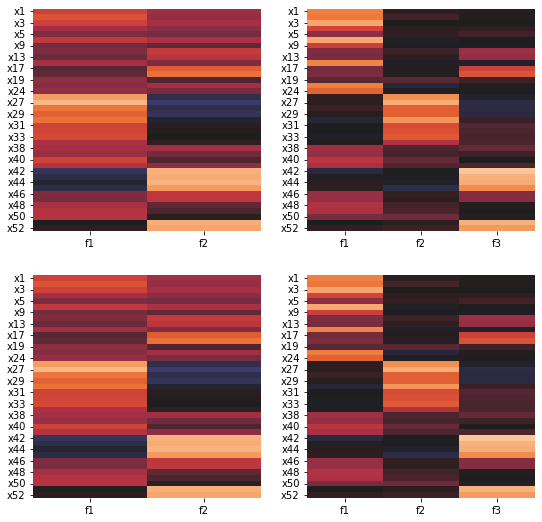

In [2]:
fig, axes = plt.subplots(2,2,figsize=(9,9))

for i, study in enumerate(['teicher2015','tuominen2022']):
    
    for j, f in enumerate([2,3]):
        
        f = 'stan_results/%s/efa_f%s_quartimax.csv' %(study, f)
        df = read_csv(f, index_col=0)
        sns.heatmap(df, vmin=-1, vmax=1, center=0, cbar=False, ax=axes[i,j])

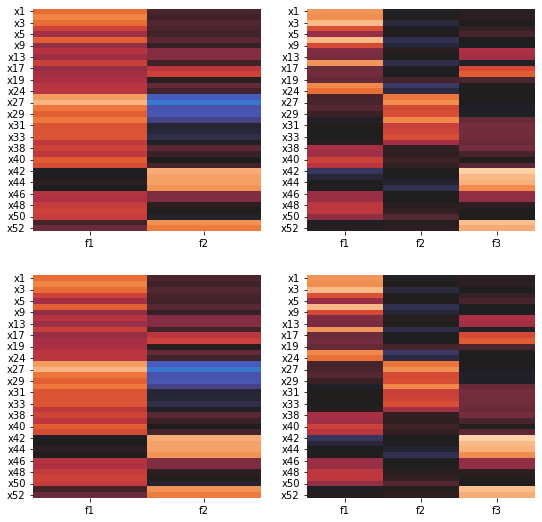

In [3]:
fig, axes = plt.subplots(2,2,figsize=(9,9))

for i, study in enumerate(['teicher2015','tuominen2022']):
    
    for j, f in enumerate([2,3]):
        
        f = 'stan_results/%s/efa_f%s_geomin.csv' %(study, f)
        df = read_csv(f, index_col=0)
        sns.heatmap(df, vmin=-1, vmax=1, center=0, cbar=False, ax=axes[i,j])